In [1]:
import sys
# to import local fuctions
sys.path.insert(0, '../tools')
import pandas as pd

from datetime import timedelta
import numpy as np
from matplotlib import pyplot as plt

from run_all import main

pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)

# Running Full Script

In [2]:
# Run for all stocks
trades = main()

# If you want to run it on a small pool of stocks
#trades = main(stocks_path='../docs/my_stocks_test.csv')

1672 stocks will be analyzed

Start Update Prices Process ...
Running Incremental Refresh
It took 66 seconds to extract prices.

Running Full Refresh of Indicators. This will take some time.
Running indicators ...
Running indicators ...
Running indicators ...
Running indicators ...
Running indicators ...
Running indicators ...
Running indicators ...
Running indicators ...
Running indicators ...
Running indicators ...
Running indicators ...
Running indicators ...
Running indicators ...
Running indicators ...
Running indicators ...
Running indicators ...
Running indicators ...
Exporting Indicators
It took 4.75 minutes to generate indicators.

Add Fundamentals
It took 3.3 minutes to update fundamentals.

Create Buy/Sell Signals
It took 0.7 minutes to generate Buy and Sell Signals

The whole process took 9.866666666666667 minutes. Happy Trading! =)


## Look at suggested trades

In [3]:
def show_me_trades(no_of_days, buy_signal, clean_data):
    
    # Define min date
    min_date = clean_data['timestamp'].max() - timedelta(days=no_of_days)
    
    relevant_columns = ['timestamp', 'symbol','name', 'industry', 'next_7d_return', 'next_14d_return', 'next_21d_return']

    # Create Metrics
    metrics = clean_data[(clean_data[buy_signal] == True)][relevant_columns]
    metrics['year'] = pd.DatetimeIndex(metrics['timestamp']).year
    metrics_a = metrics.groupby(['symbol', 'name', 'industry', 'year']).count()['timestamp'].reset_index()
    metrics_b = metrics.groupby(['symbol', 'name', 'industry', 'year']).mean()[['next_7d_return', 'next_14d_return', 'next_21d_return']].reset_index()
    metrics = pd.merge(metrics_a, metrics_b, on=['symbol', 'name', 'industry', 'year'])

    # Create set of good symbols
    list_of_good = set(metrics[(metrics['next_14d_return'] > 1) & (metrics['next_21d_return'] > 1) & (metrics['year'] >= 2019)]['symbol'])

    # Run for the past 5 days
    print('Only with past record')
    display(clean_data[(clean_data['timestamp'] > min_date) & (clean_data[buy_signal] == True) & (clean_data['symbol'].isin(list_of_good))][['timestamp', 'symbol', 'next_7d_return', 'next_14d_return', 'next_21d_return', 'close_price_x']])
    print('Everything')
    display(clean_data[(clean_data['timestamp'] > min_date) & (clean_data[buy_signal] == True)][['timestamp', 'symbol', 'next_7d_return', 'next_14d_return', 'next_21d_return']])

    # Last days buys
    last_days_symbol = set(clean_data[(clean_data['timestamp'] > min_date) & (clean_data[buy_signal] == True) & (clean_data['symbol'].isin(list_of_good))]['symbol'])
    display(metrics[metrics['symbol'].isin(last_days_symbol)].sort_values('symbol'))

In [4]:
show_me_trades(3, 'buy_signal?1', trades)


Only with past record


,timestamp,symbol,next_7d_return,next_14d_return,next_21d_return,close_price_x
322636,2020-07-20 13:30:00,MRCY,NaN,NaN,NaN,76.440002
322637,2020-07-21 20:00:01,MRCY,NaN,NaN,NaN,77.000000


Everything


,timestamp,symbol,next_7d_return,next_14d_return,next_21d_return
322636,2020-07-20 13:30:00,MRCY,NaN,NaN,NaN
322637,2020-07-21 20:00:01,MRCY,NaN,NaN,NaN


,symbol,name,industry,year,timestamp,next_7d_return,next_14d_return,next_21d_return
803,MRCY,"Mercury Systems, Inc.",Industrials,2019,10,0.995063,0.996023,1.021119
804,MRCY,"Mercury Systems, Inc.",Industrials,2020,5,1.017043,1.181704,1.225775


## Explore a Security Further

In [5]:
def create_charts_1(df, symbol, field='close_price_x', include_sell=True, what_to_print=[1,2,3,4,5]):
    # Filter using the symbol
    snap_df = df[df['symbol'] == symbol]
    
    # Plot Close Price
    snap_df[field].plot(figsize=(16,8), color='blue', alpha=0.3, label=field)
    
    # Buy and Sell Signals 
    if 1 in what_to_print:
        snap_df[snap_df['buy_signal?1'] == True][field].plot(linestyle='', marker='^', color='green', alpha = 0.5, markersize = 9, label='Buy Signal 1')
    if 2 in what_to_print:
        snap_df[snap_df['buy_signal?2'] == True][field].plot(linestyle='', marker='^', color='orange', alpha = 0.5, markersize = 9, label='Buy Signal 2')
    if 3 in what_to_print:
        snap_df[snap_df['buy_signal?3'] == True][field].plot(linestyle='', marker='^', color='blue', alpha = 0.5, markersize = 9, label='Buy Signal 3')
    if 4 in what_to_print:
        snap_df[snap_df['buy_signal?4'] == True][field].plot(linestyle='', marker='^', color='blue', alpha = 0.5, markersize = 9, label='Buy Signal 4')
    if 5 in what_to_print:
        snap_df[snap_df['buy_signal?5'] == True][field].plot(linestyle='', marker='^', color='blue', alpha = 0.5, markersize = 9, label='Buy Signal 5')
    
    if include_sell == True:
        snap_df[snap_df['sell_signal?1'] == True][field].plot(linestyle='', marker='o', color='red', alpha = 0.5, markersize = 7, label='Sell Signal')
    
    if field == 'close_price_x':
        snap_df['sma_100d'].plot(color='red', alpha = 0.5, markersize = 7, label='200d')
        snap_df['sma_50d'].plot(color='green', alpha = 0.5, markersize = 7, label='50d')
    elif field == 'macd_line':
        snap_df['macd_signal_line'].plot(color='green', alpha = 0.5, markersize = 7, label='signal_line')

    # Title
    plt.title((symbol + ' - Buy/Sell Signals using ' + field), fontsize=15)
    plt.legend()
    
    plt.show();
              

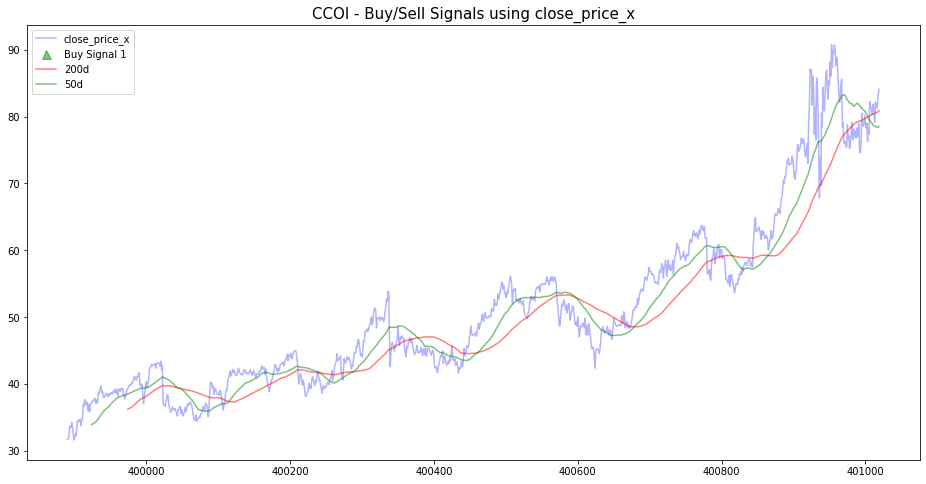

In [6]:
create_charts_1(trades, 'CCOI', what_to_print=[1], include_sell=False)

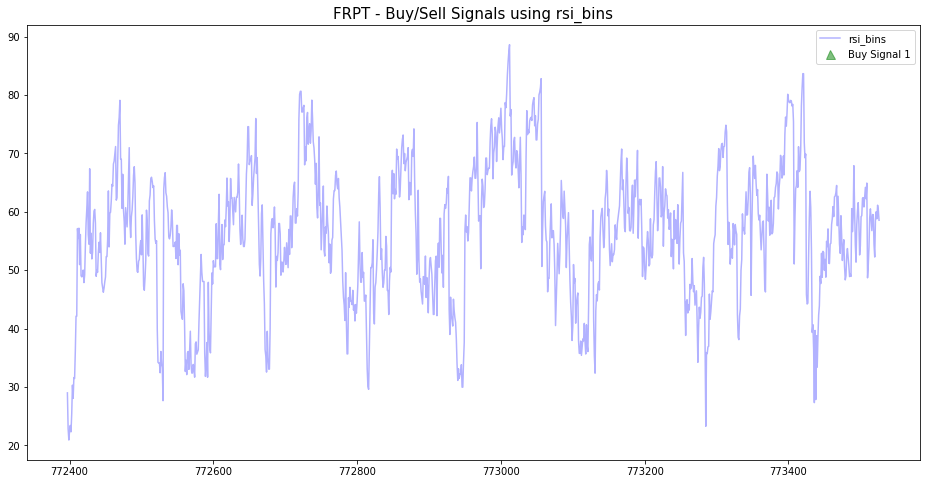

In [7]:
create_charts_1(trades, 'FRPT', what_to_print=[1], include_sell=False, field='rsi_bins')

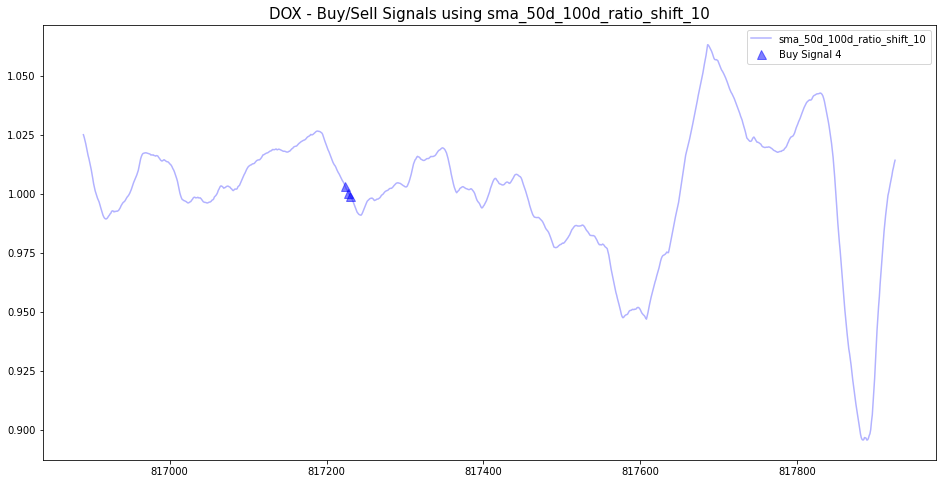

In [8]:
create_charts_1(trades, 'DOX', what_to_print=[4], include_sell=False, field='sma_50d_100d_ratio_shift_10')

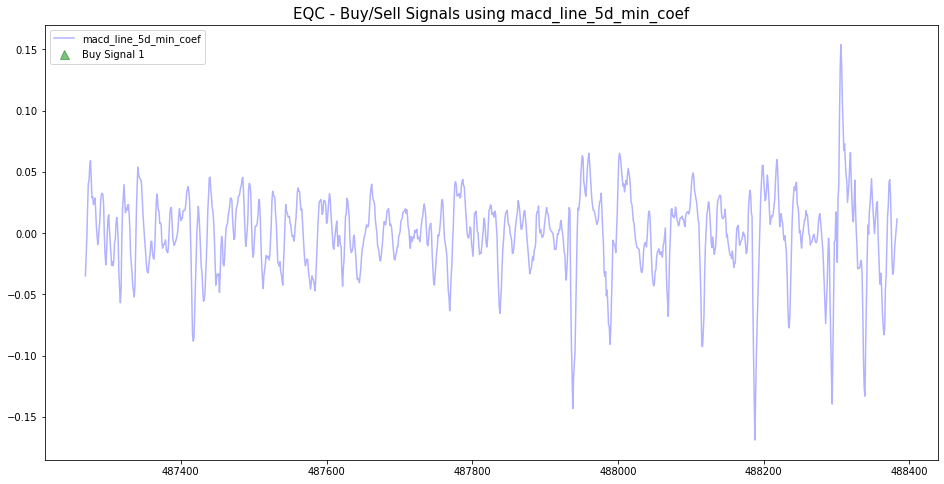

In [9]:
create_charts_1(trades, 'EQC', what_to_print=[1], include_sell=False, field='macd_line_5d_min_coef')

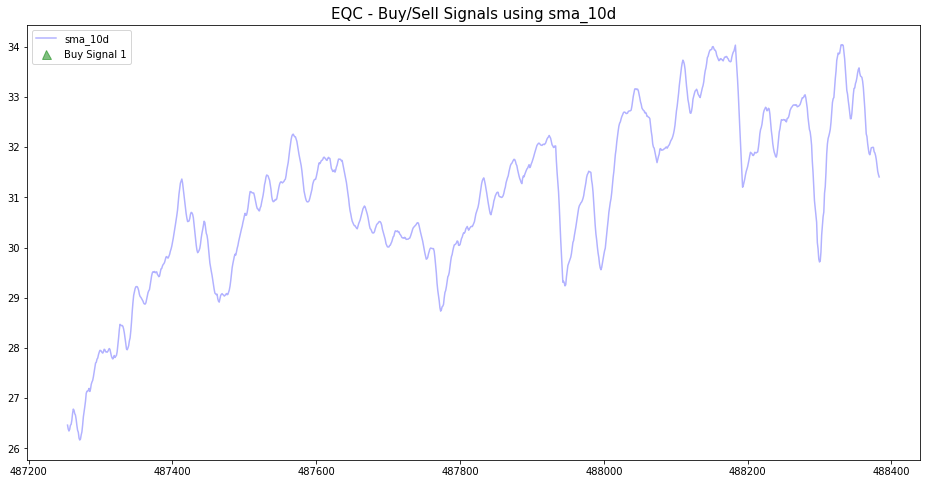

In [11]:
create_charts_1(trades, 'EQC', what_to_print=[1], include_sell=False, field='sma_10d')